['/home/jovyan/work/yolo_train/dataset/div/images/train', '/home/jovyan/work/yolo_train/dataset/guns/images/train', '/home/jovyan/work/yolo_train/dataset/vids/images/train', '/home/jovyan/work/yolo_train/dataset/films/images/train', '/home/jovyan/work/yolo_train/dataset/mixed/images/train']
['/home/jovyan/work/yolo_train/dataset/pistola/images/val', '/home/jovyan/work/yolo_train/dataset/rostlek/images/val', '/home/jovyan/work/yolo_train/dataset/september/images/val']
['/home/jovyan/work/yolo_train/dataset/div/labels/train', '/home/jovyan/work/yolo_train/dataset/guns/labels/train', '/home/jovyan/work/yolo_train/dataset/vids/labels/train', '/home/jovyan/work/yolo_train/dataset/films/labels/train', '/home/jovyan/work/yolo_train/dataset/mixed/labels/train']
['/home/jovyan/work/yolo_train/dataset/pistola/labels/val', '/home/jovyan/work/yolo_train/dataset/rostlek/labels/val', '/home/jovyan/work/yolo_train/dataset/september/labels/val']
Train images: 17847, Train annotations: 17852
Validation

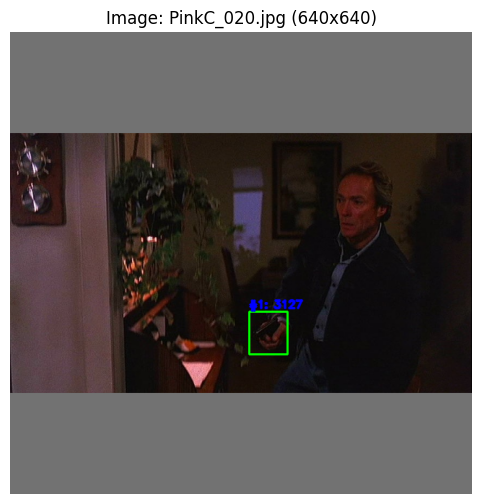

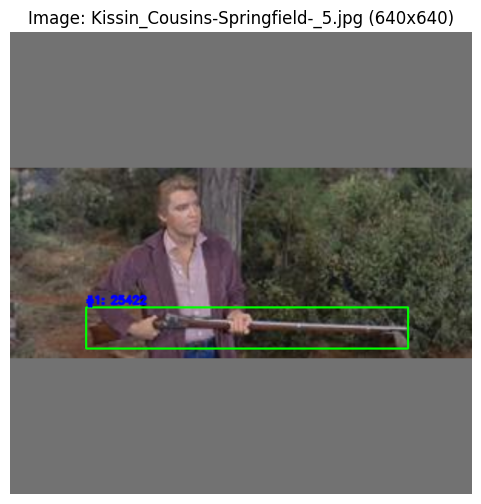

Skipping invalid line in /home/jovyan/work/yolo_train/dataset/div/labels/train/Blart2_05.txt: 


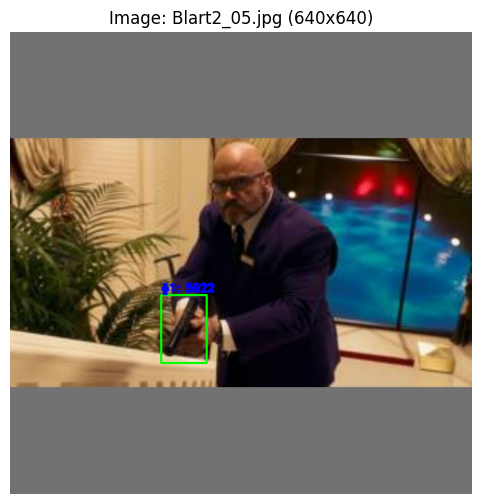

Skipping invalid line in /home/jovyan/work/yolo_train/dataset/div/labels/train/BulletforPB-SWSnub_3.txt: 


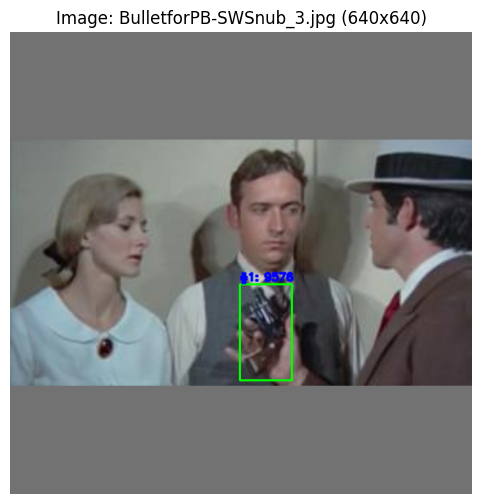

Skipping invalid line in /home/jovyan/work/yolo_train/dataset/div/labels/train/MDC_22.txt: 


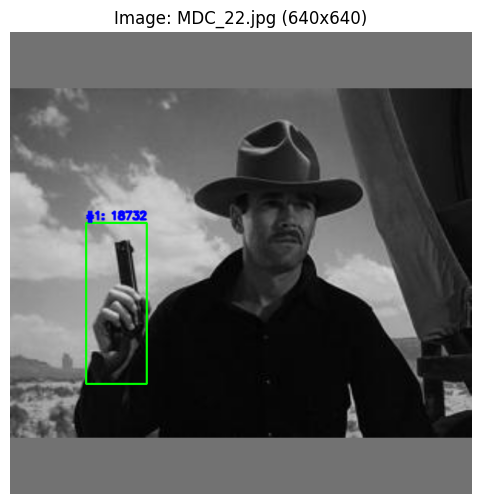

Skipping invalid line in /home/jovyan/work/yolo_train/dataset/div/labels/train/DesperadoDesertEagle-_3.txt: 


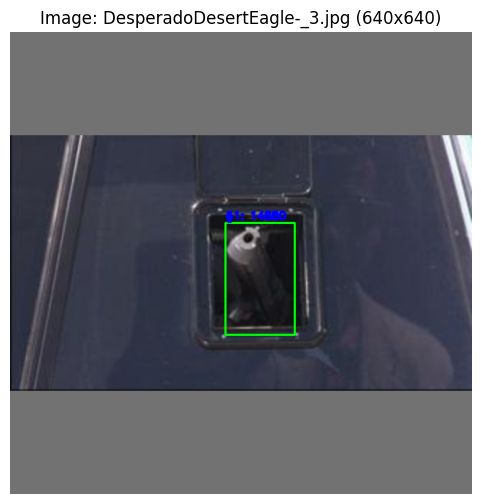

Skipping invalid line in /home/jovyan/work/yolo_train/dataset/div/labels/train/Marlowe-Hicks_45.txt: 


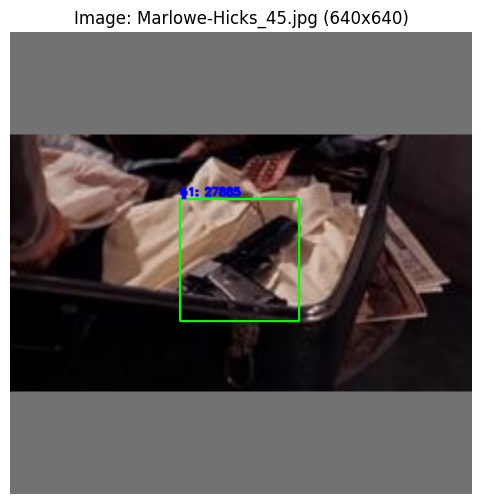

Skipping invalid line in /home/jovyan/work/yolo_train/dataset/div/labels/train/Accountant_05.txt: 


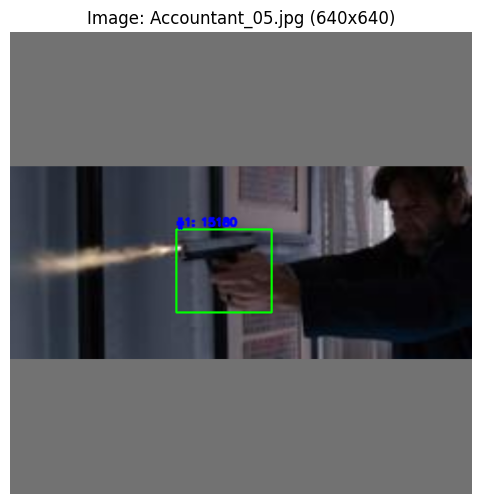

Skipping invalid line in /home/jovyan/work/yolo_train/dataset/div/labels/train/Pe2_cns_1.txt: 
Skipping invalid line in /home/jovyan/work/yolo_train/dataset/div/labels/train/Pe2_cns_1.txt: 
Skipping invalid line in /home/jovyan/work/yolo_train/dataset/div/labels/train/Pe2_cns_1.txt: 


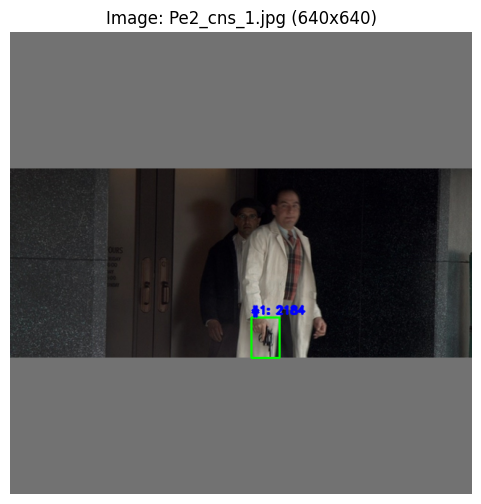

Skipping invalid line in /home/jovyan/work/yolo_train/dataset/div/labels/train/AMVY-_010.txt: 


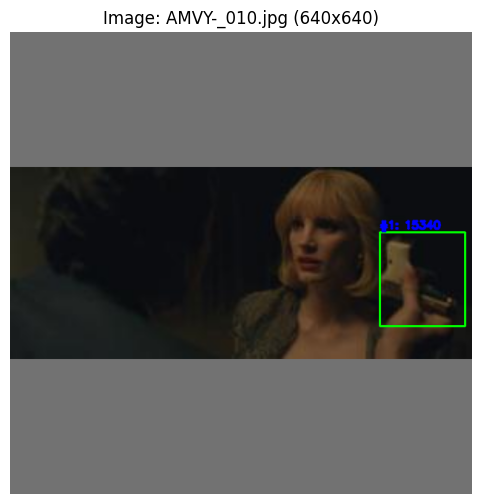

Количество боксов для каждого класса в Train наборе:
Class 1: 16853 boxes
Class 0: 5236 boxes

Количество боксов для каждого класса в Validation наборе:
Class 1: 749 boxes
Class 0: 2413 boxes

Среднеквадратическое отклонение площадей bbox для каждого класса в Validation наборе:
Class 1: 1349.66 пикселей
Class 0: 2232.25 пикселей

Среднеквадратическое отклонение  площадей bbox для каждого класса в Train наборе:
Class 1: 10668.69 пикселей
Class 0: 12019.05 пикселей

Медиана площадей bbox для каждого класса в Validation наборе:
Class 1: 160.00 пикселей
Class 0: 936.00 пикселей

Медиана площадей bbox для каждого класса в Train наборе:
Class 1: 9462.00 пикселей
Class 0: 13135.00 пикселей


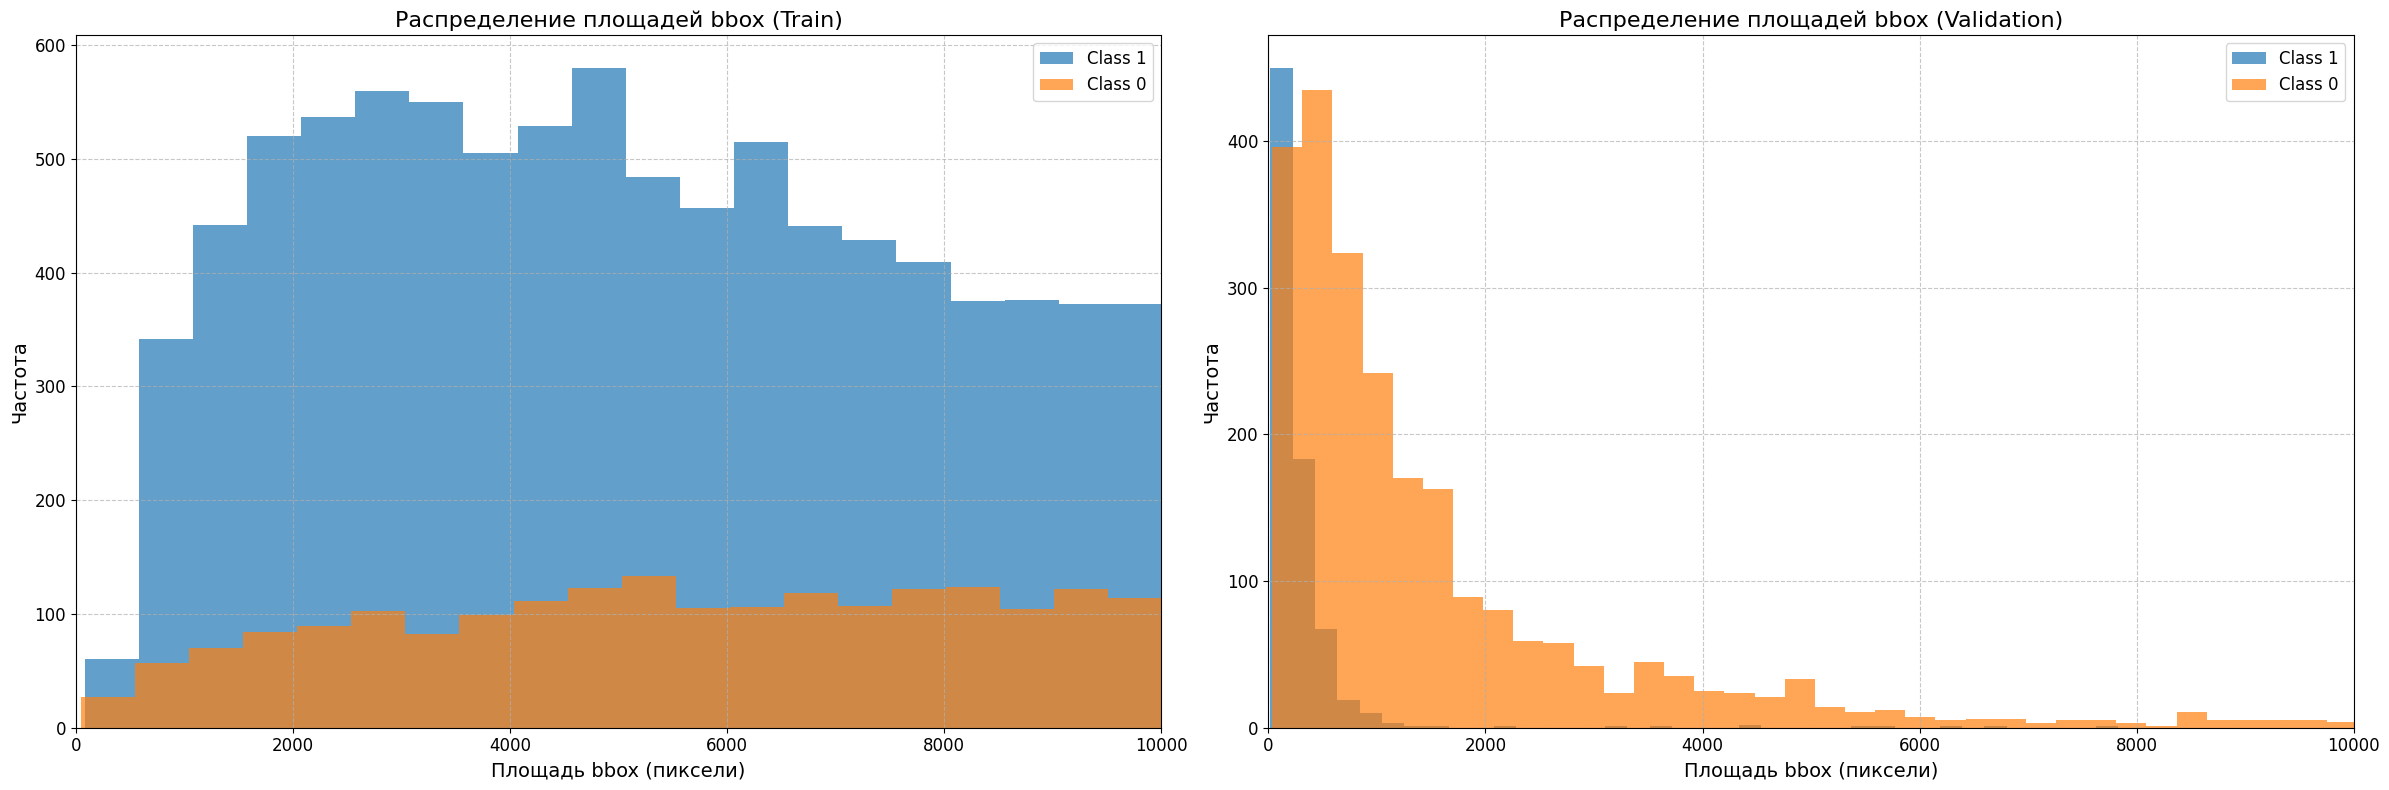

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import os
import glob
import yaml

# Функция для загрузки данных из YAML-файла
def load_yaml_config(yaml_path):
    with open(yaml_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# Загрузка конфигурации из YAML-файла
yaml_path = '/home/jovyan/work/yolo_train/data.yaml'  # Укажите путь к вашему YAML-файлу
config = load_yaml_config(yaml_path)

# Получение базового пути и путей для обучения и валидации
base_path = config['path']
train_paths = [os.path.join(base_path, path) for path in config['train_images']]
print(train_paths)
val_paths = [os.path.join(base_path, path) for path in config['val_images']]
print(val_paths)
train_ann_paths = [os.path.join(base_path, path) for path in config['train_annotations']]
print(train_ann_paths)
val_ann_paths = [os.path.join(base_path, path) for path in config['val_annotations']]
print(val_ann_paths)

# Сбор всех путей к изображениям и аннотациям
def collect_data_paths(image_paths, ann_paths):
    img_list = []
    ann_list = []
    for img_path, ann_path in zip(image_paths, ann_paths):
        img_list.extend(glob.glob(os.path.join(img_path, "*.jpg")))
        img_list.extend(glob.glob(os.path.join(img_path, "*.png")))
        ann_list.extend(glob.glob(os.path.join(ann_path, "*.txt")))
    return img_list, ann_list

# Сбор данных для обучения и валидации
train_img, train_ann = collect_data_paths(train_paths, train_ann_paths)
val_img, val_ann = collect_data_paths(val_paths, val_ann_paths)

# Проверка количества данных
print(f"Train images: {len(train_img)}, Train annotations: {len(train_ann)}")
print(f"Validation images: {len(val_img)}, Validation annotations: {len(val_ann)}")

# Функция letterbox
def letterbox(image, target_size=(640, 640), color=(114, 114, 114)):
    h, w = image.shape[:2]
    target_h, target_w = target_size

    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    padded_image = np.full((target_h, target_w, 3), color, dtype=np.uint8)
    pad_top = (target_h - new_h) // 2
    pad_left = (target_w - new_w) // 2
    padded_image[pad_top:pad_top + new_h, pad_left:pad_left + new_w] = resized_image

    return padded_image, scale, (pad_left, pad_top)

# Функция для корректировки bbox
def adjust_bbox(bbox, scale, pad_left, pad_top):
    x_min, y_min, x_max, y_max = bbox
    x_min = x_min * scale + pad_left
    y_min = y_min * scale + pad_top
    x_max = x_max * scale + pad_left
    y_max = y_max * scale + pad_top
    return (int(x_min), int(y_min), int(x_max), int(y_max))

# Функция для расчета площади bbox
def calculate_bbox_area(bbox):
    x_min, y_min, x_max, y_max = bbox
    return (x_max - x_min) * (y_max - y_min)

# Функция для обработки аннотаций
def process_annotations(image, annotation_path, padded_image, scale, pad_left, pad_top, bbox_areas_by_class):
    if not os.path.exists(annotation_path):
        print(f"Annotation file not found: {annotation_path}")
        return

    with open(annotation_path, "r") as f:
        lines = f.readlines()

    bbox_counter = 1
    for line in lines:
        try:
            class_id, x_center, y_center, w, h = map(float, line.strip().split())
        except ValueError:
            print(f"Skipping invalid line in {annotation_path}: {line.strip()}")
            continue

        x_min = (x_center - w / 2) * image.shape[1]
        y_min = (y_center - h / 2) * image.shape[0]
        x_max = (x_center + w / 2) * image.shape[1]
        y_max = (y_center + h / 2) * image.shape[0]

        bbox = adjust_bbox((x_min, y_min, x_max, y_max), scale, pad_left, pad_top)
        bbox_area = calculate_bbox_area(bbox)

        if class_id not in bbox_areas_by_class:
            bbox_areas_by_class[class_id] = []
        bbox_areas_by_class[class_id].append(bbox_area)

        cv2.rectangle(padded_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        cv2.putText(
            padded_image,
            f"#{bbox_counter}: {int(bbox_area)}",
            (bbox[0], bbox[1] - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 0, 0),
            2,
            cv2.LINE_AA
        )
        bbox_counter += 1

# Функция для обработки данных
def process_data(image_list, annotation_list, max_area=50000):
    bbox_areas = {}
    bbox_counts = {}

    for image_path, annotation_path in zip(image_list, annotation_list):
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image: {image_path}")
            continue

        padded_image, scale, (pad_left, pad_top) = letterbox(image, target_size=(640, 640))

        with open(annotation_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            try:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
            except ValueError:
                # print(f"Skipping invalid line in {annotation_path}: {line.strip()}")
                continue

            x_min = (x_center - width / 2) * image.shape[1]
            y_min = (y_center - height / 2) * image.shape[0]
            x_max = (x_center + width / 2) * image.shape[1]
            y_max = (y_center + height / 2) * image.shape[0]

            bbox = adjust_bbox((x_min, y_min, x_max, y_max), scale, pad_left, pad_top)
            bbox_area = calculate_bbox_area(bbox)

            if bbox_area <= max_area:
                if class_id not in bbox_areas:
                    bbox_areas[class_id] = []
                bbox_areas[class_id].append(bbox_area)

                if class_id not in bbox_counts:
                    bbox_counts[class_id] = 0
                bbox_counts[class_id] += 1

    return bbox_areas, bbox_counts

# Обработка данных
bbox_areas_by_class = {}
for image_path in train_img[:10]:  # Обрабатываем первые 10 изображений из обучающей выборки
    image_name = os.path.basename(image_path)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image: {image_path}")
        continue

    padded_image, scale, (pad_left, pad_top) = letterbox(image, target_size=(640, 640))
    label_path = image_path.replace("/images/", "/labels/").replace(".jpg", ".txt").replace(".png", ".txt")

    process_annotations(image, label_path, padded_image, scale, pad_left, pad_top, bbox_areas_by_class)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(padded_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Image: {image_name} ({padded_image.shape[1]}x{padded_image.shape[0]})")
    plt.axis('off')
    plt.show()

# Обработка обучающих и валидационных данных
train_bbox_areas, train_bbox_counts = process_data(train_img, train_ann)
val_bbox_areas, val_bbox_counts = process_data(val_img, val_ann)


print("Количество боксов для каждого класса в Train наборе:")
for class_id, count in train_bbox_counts.items():
    print(f"Class {int(class_id)}: {count} boxes")

print("\nКоличество боксов для каждого класса в Validation наборе:")
for class_id, count in val_bbox_counts.items():
    print(f"Class {int(class_id)}: {count} boxes")


# Вычисление среднеквадратического отклонения площадей bbox для каждого класса 
val_bbox_variance = {}
for class_id, areas in val_bbox_areas.items():
    val_bbox_variance[class_id] = np.sqrt(np.var(areas))

train_bbox_variance = {}
for class_id, areas in train_bbox_areas.items():
    train_bbox_variance[class_id] = np.sqrt(np.var(areas))

# Вывод среднеквадратического отклонения площадей bbox для каждого класса
print("\nСреднеквадратическое отклонение площадей bbox для каждого класса в Validation наборе:")
for class_id, var_area in val_bbox_variance.items():
    print(f"Class {int(class_id)}: {var_area:.2f} пикселей")

print("\nСреднеквадратическое отклонение  площадей bbox для каждого класса в Train наборе:")
for class_id, var_area in train_bbox_variance.items():
    print(f"Class {int(class_id)}: {var_area:.2f} пикселей")

# Вычисление медианы площадей bbox для каждого класса в валидационных данных
val_bbox_med = {}
for class_id, areas in val_bbox_areas.items():
    val_bbox_med[class_id] = np.median(areas)

train_bbox_med = {}
for class_id, areas in train_bbox_areas.items():
    train_bbox_med[class_id] = np.median(areas)

# Вывод медиан площадей bbox для каждого класса в валидационных данных
print("\nМедиана площадей bbox для каждого класса в Validation наборе:")
for class_id, median_area in val_bbox_med.items():
    print(f"Class {int(class_id)}: {median_area:.2f} пикселей")

print("\nМедиана площадей bbox для каждого класса в Train наборе:")
for class_id, median_area in train_bbox_med.items():
    print(f"Class {int(class_id)}: {median_area:.2f} пикселей")

# Визуализация распределения площадей bbox
plt.figure(figsize=(24, 8))

plt.subplot(1, 2, 1)
for class_id, areas in train_bbox_areas.items():
    plt.hist(areas, bins=100, alpha=0.7, label=f"Class {int(class_id)}")
plt.title("Распределение площадей bbox (Train)", fontsize=16)
plt.xlabel("Площадь bbox (пиксели)", fontsize=14)
plt.ylabel("Частота", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xlim(0, 10000)

plt.subplot(1, 2, 2)
for class_id, areas in val_bbox_areas.items():
    plt.hist(areas, bins=100, alpha=0.7, label=f"Class {int(class_id)}")
plt.title("Распределение площадей bbox (Validation)", fontsize=16)
plt.xlabel("Площадь bbox (пиксели)", fontsize=14)
plt.ylabel("Частота", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xlim(0, 10000)

plt.tight_layout()
plt.show()


['/home/jovyan/work/yolo_train/padded/div/images/', '/home/jovyan/work/yolo_train/padded/only_guns/images/', '/home/jovyan/work/yolo_train/padded/guns/images/', '/home/jovyan/work/yolo_train/padded/vids/images/', '/home/jovyan/work/yolo_train/padded/films/images/', '/home/jovyan/work/yolo_train/padded/mixed/images/']
['/home/jovyan/work/yolo_train/padded/pistola/images/', '/home/jovyan/work/yolo_train/padded/rostlek/images/', '/home/jovyan/work/yolo_train/padded/september/images/']
['/home/jovyan/work/yolo_train/padded/div/labels/', '/home/jovyan/work/yolo_train/padded/only_guns/labels/', '/home/jovyan/work/yolo_train/padded/guns/labels/', '/home/jovyan/work/yolo_train/padded/vids/labels/', '/home/jovyan/work/yolo_train/padded/films/labels/', '/home/jovyan/work/yolo_train/padded/mixed/labels/']
['/home/jovyan/work/yolo_train/padded/pistola/labels/', '/home/jovyan/work/yolo_train/padded/rostlek/labels/', '/home/jovyan/work/yolo_train/padded/september/labels/']
Train images: 19292, Train

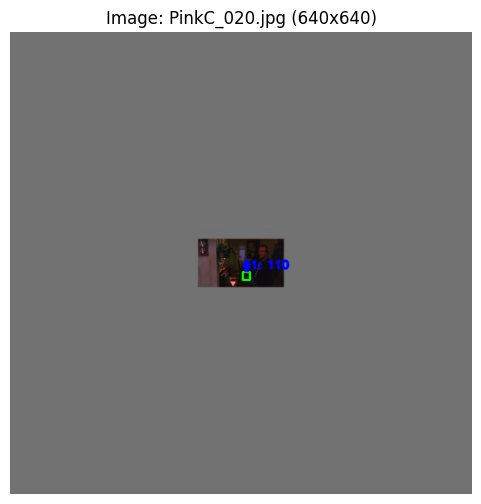

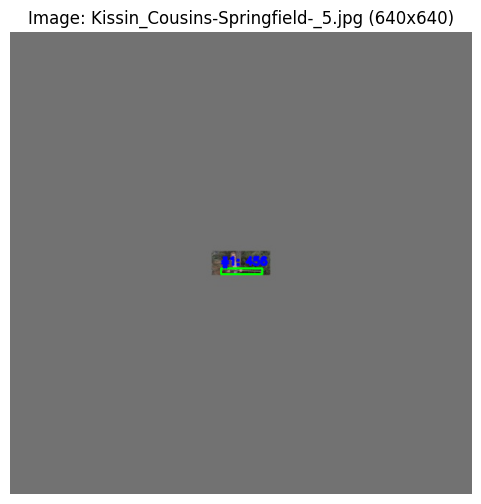

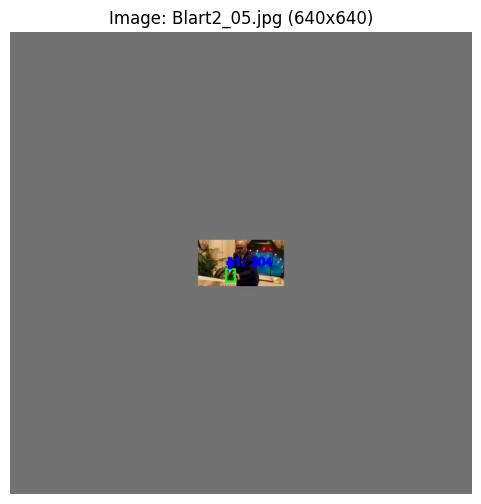

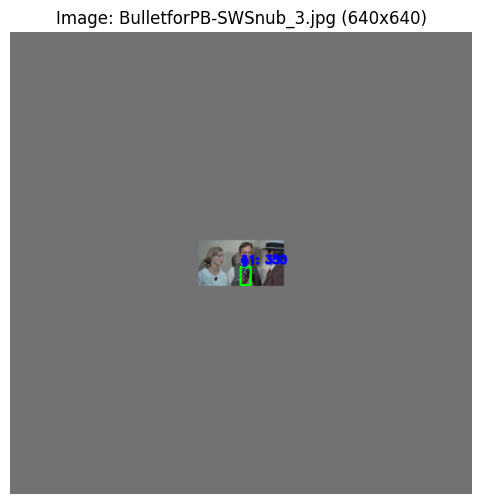

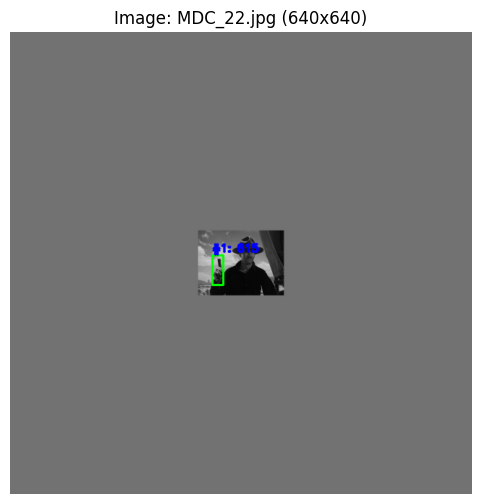

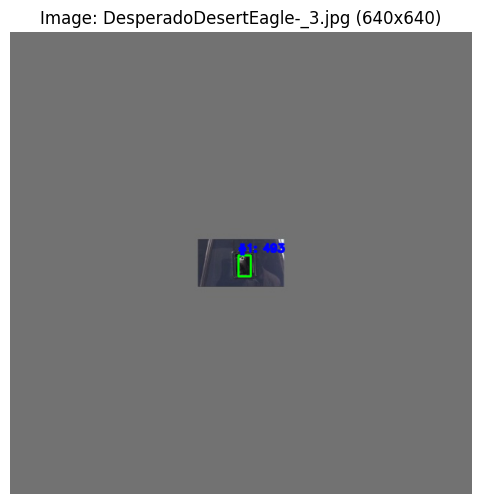

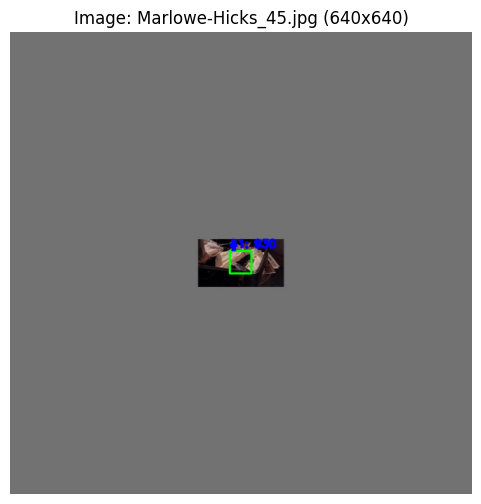

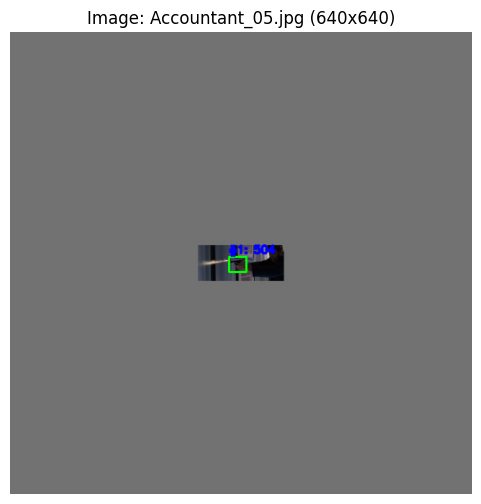

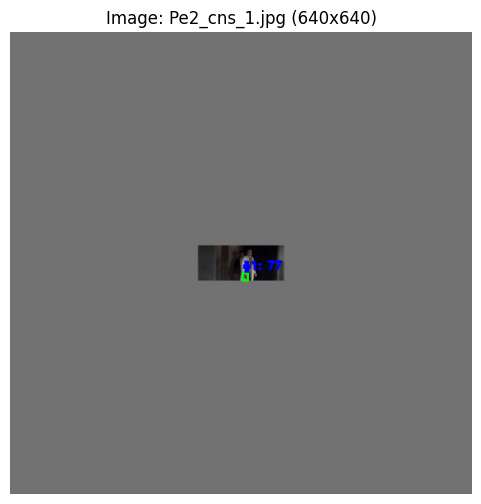

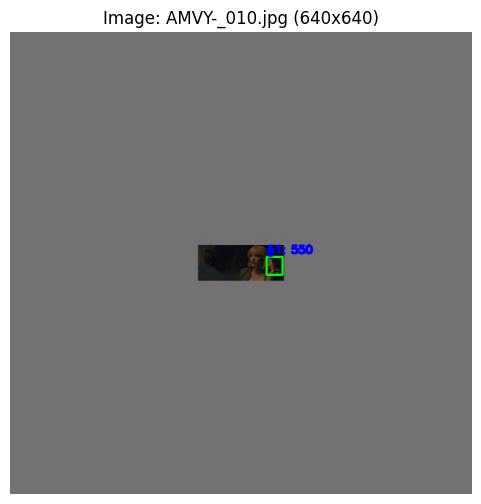

Количество боксов для каждого класса в Train наборе:
Class 1: 18540 boxes
Class 0: 6550 boxes

Количество боксов для каждого класса в Validation наборе:
Class 1: 749 boxes
Class 0: 2413 boxes

Среднеквадратическое отклонение площадей bbox для каждого класса в Validation наборе:
Class 1: 1349.66 пикселей
Class 0: 2232.25 пикселей

Среднеквадратическое отклонение  площадей bbox для каждого класса в Train наборе:
Class 1: 4614.25 пикселей
Class 0: 7226.09 пикселей

Медиана площадей bbox для каждого класса в Validation наборе:
Class 1: 160.00 пикселей
Class 0: 936.00 пикселей

Медиана площадей bbox для каждого класса в Train наборе:
Class 1: 462.00 пикселей
Class 0: 900.00 пикселей


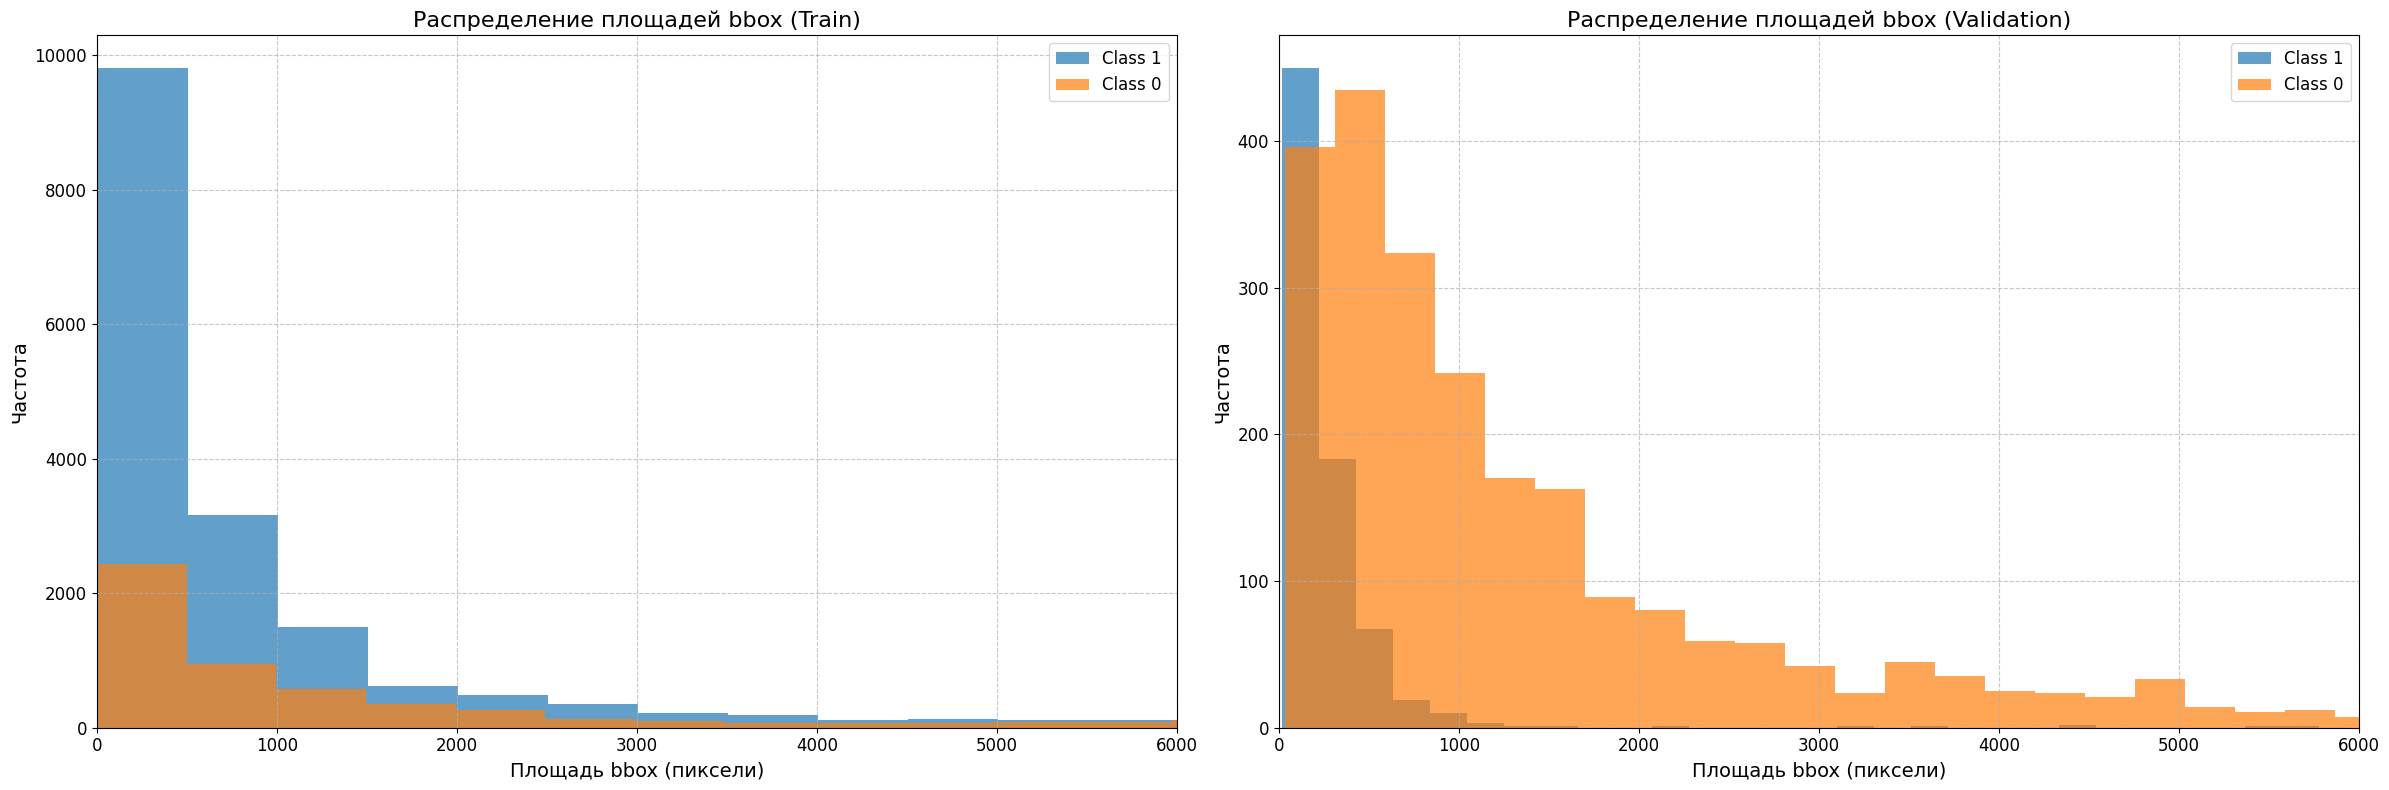

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import os
import glob
import yaml

# Функция для загрузки данных из YAML-файла
def load_yaml_config(yaml_path):
    with open(yaml_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# Загрузка конфигурации из YAML-файла
yaml_path = '/home/jovyan/work/yolo_train/padded_config.yaml'  # Укажите путь к вашему YAML-файлу
config = load_yaml_config(yaml_path)

# Получение базового пути и путей для обучения и валидации
base_path = config['path']
train_paths = [os.path.join(base_path, path) for path in config['train_images']]
print(train_paths)
val_paths = [os.path.join(base_path, path) for path in config['val_images']]
print(val_paths)
train_ann_paths = [os.path.join(base_path, path) for path in config['train_annotations']]
print(train_ann_paths)
val_ann_paths = [os.path.join(base_path, path) for path in config['val_annotations']]
print(val_ann_paths)

# Сбор всех путей к изображениям и аннотациям
def collect_data_paths(image_paths, ann_paths):
    img_list = []
    ann_list = []
    for img_path, ann_path in zip(image_paths, ann_paths):
        img_list.extend(glob.glob(os.path.join(img_path, "*.jpg")))
        img_list.extend(glob.glob(os.path.join(img_path, "*.png")))
        ann_list.extend(glob.glob(os.path.join(ann_path, "*.txt")))
    return img_list, ann_list

# Сбор данных для обучения и валидации
train_img, train_ann = collect_data_paths(train_paths, train_ann_paths)
val_img, val_ann = collect_data_paths(val_paths, val_ann_paths)

# Проверка количества данных
print(f"Train images: {len(train_img)}, Train annotations: {len(train_ann)}")
print(f"Validation images: {len(val_img)}, Validation annotations: {len(val_ann)}")

# Функция letterbox
def letterbox(image, target_size=(640, 640), color=(114, 114, 114)):
    h, w = image.shape[:2]
    target_h, target_w = target_size

    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    padded_image = np.full((target_h, target_w, 3), color, dtype=np.uint8)
    pad_top = (target_h - new_h) // 2
    pad_left = (target_w - new_w) // 2
    padded_image[pad_top:pad_top + new_h, pad_left:pad_left + new_w] = resized_image

    return padded_image, scale, (pad_left, pad_top)

# Функция для корректировки bbox
def adjust_bbox(bbox, scale, pad_left, pad_top):
    x_min, y_min, x_max, y_max = bbox
    x_min = x_min * scale + pad_left
    y_min = y_min * scale + pad_top
    x_max = x_max * scale + pad_left
    y_max = y_max * scale + pad_top
    return (int(x_min), int(y_min), int(x_max), int(y_max))

# Функция для расчета площади bbox
def calculate_bbox_area(bbox):
    x_min, y_min, x_max, y_max = bbox
    return (x_max - x_min) * (y_max - y_min)

# Функция для обработки аннотаций
def process_annotations(image, annotation_path, padded_image, scale, pad_left, pad_top, bbox_areas_by_class):
    if not os.path.exists(annotation_path):
        print(f"Annotation file not found: {annotation_path}")
        return

    with open(annotation_path, "r") as f:
        lines = f.readlines()

    bbox_counter = 1
    for line in lines:
        try:
            class_id, x_center, y_center, w, h = map(float, line.strip().split())
        except ValueError:
            print(f"Skipping invalid line in {annotation_path}: {line.strip()}")
            continue

        x_min = (x_center - w / 2) * image.shape[1]
        y_min = (y_center - h / 2) * image.shape[0]
        x_max = (x_center + w / 2) * image.shape[1]
        y_max = (y_center + h / 2) * image.shape[0]

        bbox = adjust_bbox((x_min, y_min, x_max, y_max), scale, pad_left, pad_top)
        bbox_area = calculate_bbox_area(bbox)

        if class_id not in bbox_areas_by_class:
            bbox_areas_by_class[class_id] = []
        bbox_areas_by_class[class_id].append(bbox_area)

        cv2.rectangle(padded_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        cv2.putText(
            padded_image,
            f"#{bbox_counter}: {int(bbox_area)}",
            (bbox[0], bbox[1] - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 0, 0),
            2,
            cv2.LINE_AA
        )
        bbox_counter += 1

# Функция для обработки данных
def process_data(image_list, annotation_list, max_area=50000):
    bbox_areas = {}
    bbox_counts = {}

    for image_path, annotation_path in zip(image_list, annotation_list):
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image: {image_path}")
            continue

        padded_image, scale, (pad_left, pad_top) = letterbox(image, target_size=(640, 640))

        with open(annotation_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            try:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
            except ValueError:
                # print(f"Skipping invalid line in {annotation_path}: {line.strip()}")
                continue

            x_min = (x_center - width / 2) * image.shape[1]
            y_min = (y_center - height / 2) * image.shape[0]
            x_max = (x_center + width / 2) * image.shape[1]
            y_max = (y_center + height / 2) * image.shape[0]

            bbox = adjust_bbox((x_min, y_min, x_max, y_max), scale, pad_left, pad_top)
            bbox_area = calculate_bbox_area(bbox)

            if bbox_area <= max_area:
                if class_id not in bbox_areas:
                    bbox_areas[class_id] = []
                bbox_areas[class_id].append(bbox_area)

                if class_id not in bbox_counts:
                    bbox_counts[class_id] = 0
                bbox_counts[class_id] += 1

    return bbox_areas, bbox_counts

# Обработка данных
bbox_areas_by_class = {}
for image_path in train_img[:10]:  # Обрабатываем первые 10 изображений из обучающей выборки
    image_name = os.path.basename(image_path)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image: {image_path}")
        continue

    padded_image, scale, (pad_left, pad_top) = letterbox(image, target_size=(640, 640))
    label_path = image_path.replace("/images/", "/labels/").replace(".jpg", ".txt").replace(".png", ".txt")

    process_annotations(image, label_path, padded_image, scale, pad_left, pad_top, bbox_areas_by_class)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(padded_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Image: {image_name} ({padded_image.shape[1]}x{padded_image.shape[0]})")
    plt.axis('off')
    plt.show()

# Обработка обучающих и валидационных данных
train_bbox_areas, train_bbox_counts = process_data(train_img, train_ann)
val_bbox_areas, val_bbox_counts = process_data(val_img, val_ann)


print("Количество боксов для каждого класса в Train наборе:")
for class_id, count in train_bbox_counts.items():
    print(f"Class {int(class_id)}: {count} boxes")

print("\nКоличество боксов для каждого класса в Validation наборе:")
for class_id, count in val_bbox_counts.items():
    print(f"Class {int(class_id)}: {count} boxes")


# Вычисление среднеквадратического отклонения площадей bbox для каждого класса 
val_bbox_variance = {}
for class_id, areas in val_bbox_areas.items():
    val_bbox_variance[class_id] = np.sqrt(np.var(areas))

train_bbox_variance = {}
for class_id, areas in train_bbox_areas.items():
    train_bbox_variance[class_id] = np.sqrt(np.var(areas))

# Вывод среднеквадратического отклонения площадей bbox для каждого класса
print("\nСреднеквадратическое отклонение площадей bbox для каждого класса в Validation наборе:")
for class_id, var_area in val_bbox_variance.items():
    print(f"Class {int(class_id)}: {var_area:.2f} пикселей")

print("\nСреднеквадратическое отклонение  площадей bbox для каждого класса в Train наборе:")
for class_id, var_area in train_bbox_variance.items():
    print(f"Class {int(class_id)}: {var_area:.2f} пикселей")

# Вычисление медианы площадей bbox для каждого класса в валидационных данных
val_bbox_med = {}
for class_id, areas in val_bbox_areas.items():
    val_bbox_med[class_id] = np.median(areas)

train_bbox_med = {}
for class_id, areas in train_bbox_areas.items():
    train_bbox_med[class_id] = np.median(areas)

# Вывод медиан площадей bbox для каждого класса в валидационных данных
print("\nМедиана площадей bbox для каждого класса в Validation наборе:")
for class_id, median_area in val_bbox_med.items():
    print(f"Class {int(class_id)}: {median_area:.2f} пикселей")

print("\nМедиана площадей bbox для каждого класса в Train наборе:")
for class_id, median_area in train_bbox_med.items():
    print(f"Class {int(class_id)}: {median_area:.2f} пикселей")

# Визуализация распределения площадей bbox
plt.figure(figsize=(24, 8))

# График для обучающих данных
plt.subplot(1, 2, 1)
for class_id, areas in train_bbox_areas.items():
    plt.hist(areas, bins=100, alpha=0.7, label=f"Class {int(class_id)}")
plt.title("Распределение площадей bbox (Train)", fontsize=16)
plt.xlabel("Площадь bbox (пиксели)", fontsize=14)
plt.ylabel("Частота", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xlim(0, 6000)  # Обрезаем график до 6000 по оси X

# График для валидационных данных
plt.subplot(1, 2, 2)
for class_id, areas in val_bbox_areas.items():
    plt.hist(areas, bins=100, alpha=0.7, label=f"Class {int(class_id)}")
plt.title("Распределение площадей bbox (Validation)", fontsize=16)
plt.xlabel("Площадь bbox (пиксели)", fontsize=14)
plt.ylabel("Частота", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xlim(0, 6000)  # Обрезаем график до 6000 по оси X

plt.tight_layout()
plt.show()


['/home/jovyan/work/yolo_train/padded/div/images/', '/home/jovyan/work/yolo_train/padded/only_guns/images/', '/home/jovyan/work/yolo_train/padded/guns/images/', '/home/jovyan/work/yolo_train/padded/vids/images/', '/home/jovyan/work/yolo_train/padded/films/images/', '/home/jovyan/work/yolo_train/padded/mixed/images/']
['/home/jovyan/work/yolo_train/padded/pistola/images/', '/home/jovyan/work/yolo_train/padded/rostlek/images/', '/home/jovyan/work/yolo_train/padded/september/images/']
['/home/jovyan/work/yolo_train/padded/div/labels/', '/home/jovyan/work/yolo_train/padded/only_guns/labels/', '/home/jovyan/work/yolo_train/padded/guns/labels/', '/home/jovyan/work/yolo_train/padded/vids/labels/', '/home/jovyan/work/yolo_train/padded/films/labels/', '/home/jovyan/work/yolo_train/padded/mixed/labels/']
['/home/jovyan/work/yolo_train/padded/pistola/labels/', '/home/jovyan/work/yolo_train/padded/rostlek/labels/', '/home/jovyan/work/yolo_train/padded/september/labels/']
Train images: 19292, Train

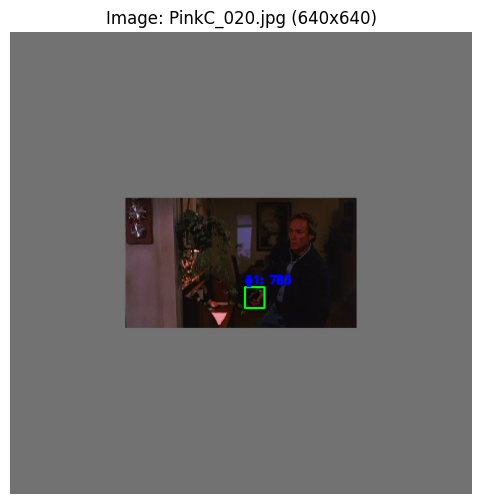

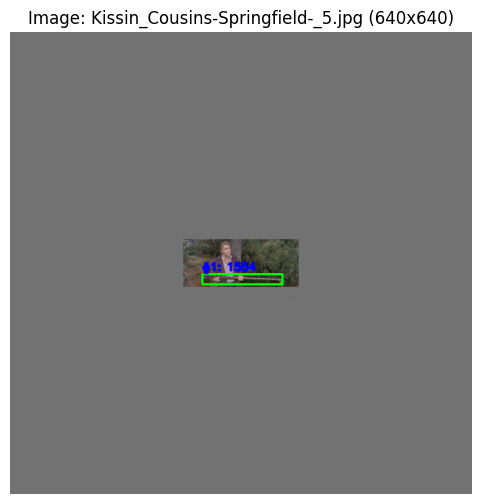

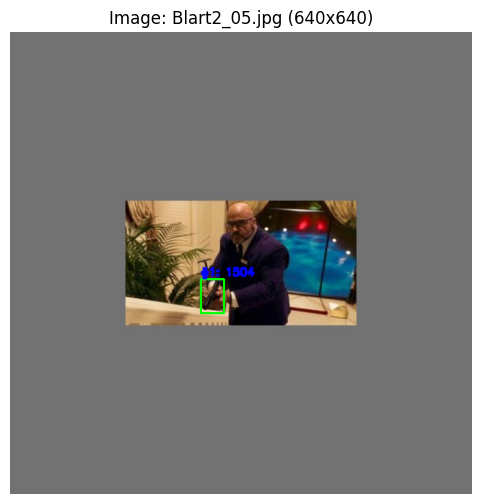

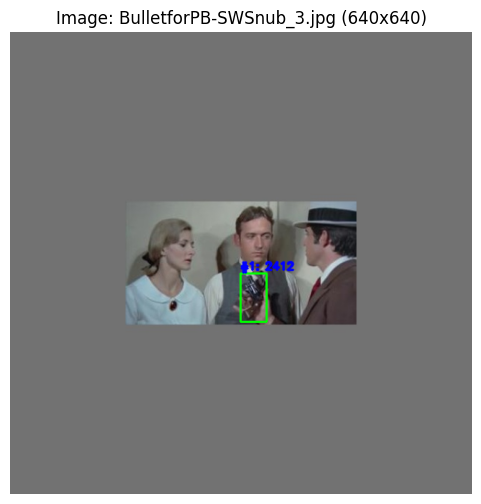

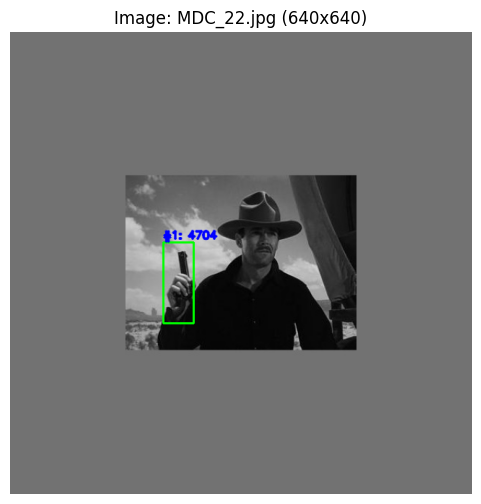

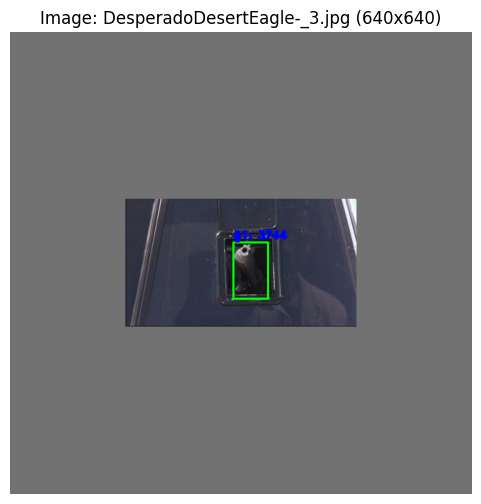

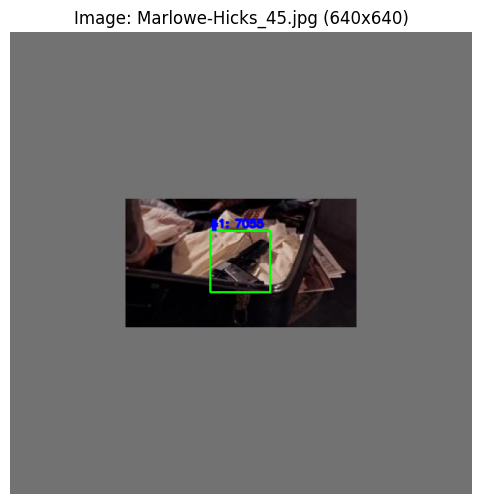

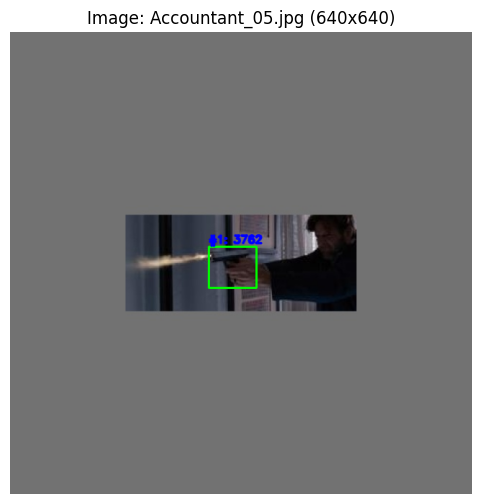

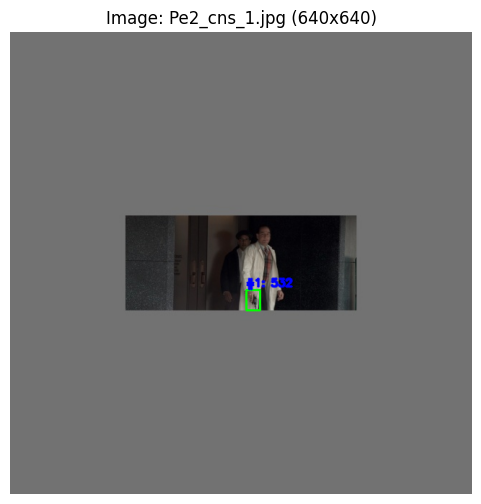

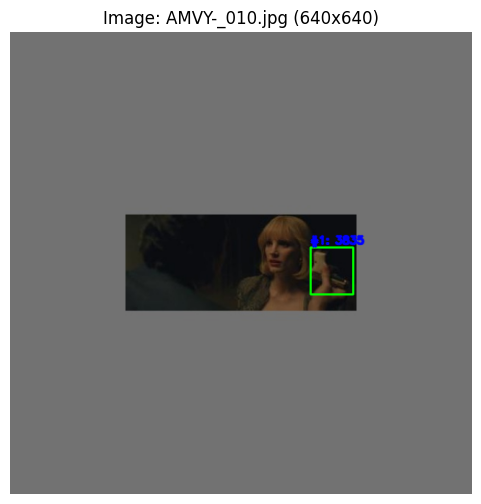

Количество боксов для каждого класса в Train наборе:
Class 1: 18208 boxes
Class 0: 6550 boxes

Количество боксов для каждого класса в Validation наборе:
Class 1: 749 boxes
Class 0: 2413 boxes

Среднеквадратическое отклонение площадей bbox для каждого класса в Validation наборе:
Class 1: 1349.66 пикселей
Class 0: 2232.25 пикселей

Среднеквадратическое отклонение  площадей bbox для каждого класса в Train наборе:
Class 1: 7155.28 пикселей
Class 0: 7050.17 пикселей

Медиана площадей bbox для каждого класса в Validation наборе:
Class 1: 160.00 пикселей
Class 0: 936.00 пикселей

Медиана площадей bbox для каждого класса в Train наборе:
Class 1: 2948.00 пикселей
Class 0: 2709.00 пикселей


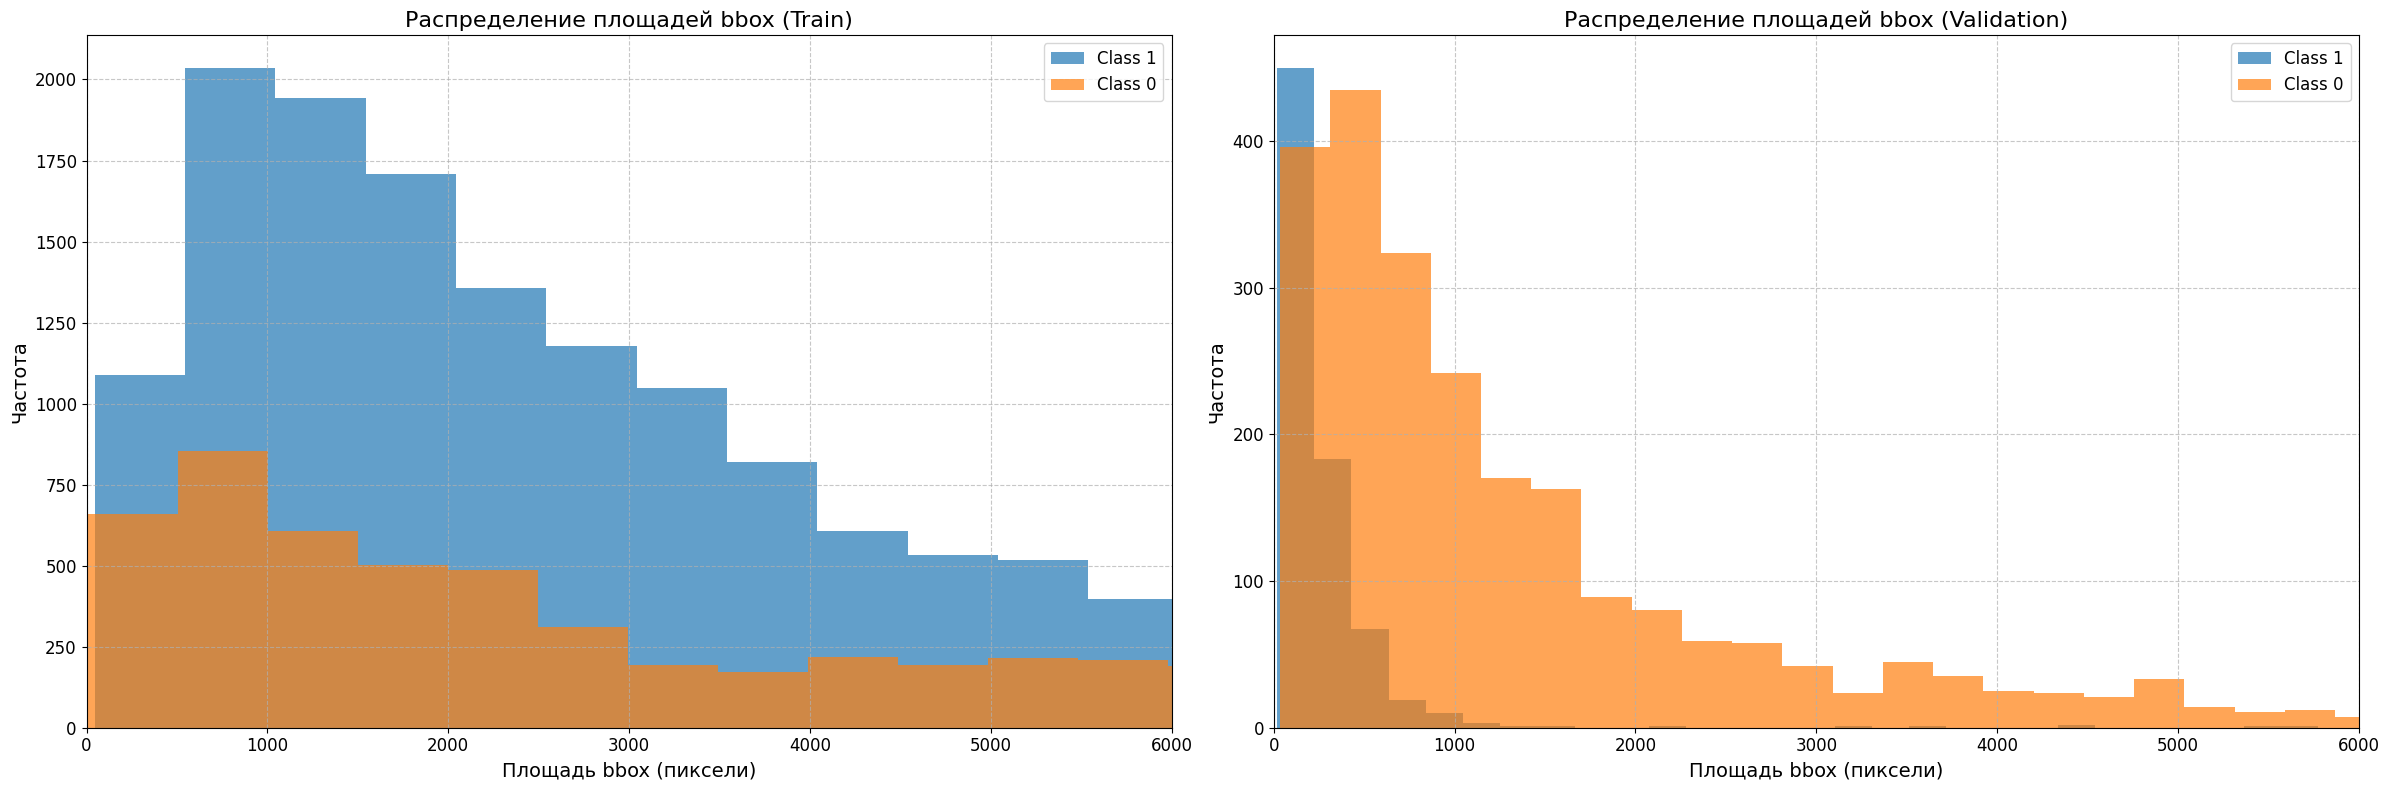

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import os
import glob
import yaml

# Функция для загрузки данных из YAML-файла
def load_yaml_config(yaml_path):
    with open(yaml_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# Загрузка конфигурации из YAML-файла
yaml_path = '/home/jovyan/work/yolo_train/padded_config.yaml'  # Укажите путь к вашему YAML-файлу
config = load_yaml_config(yaml_path)

# Получение базового пути и путей для обучения и валидации
base_path = config['path']
train_paths = [os.path.join(base_path, path) for path in config['train_images']]
print(train_paths)
val_paths = [os.path.join(base_path, path) for path in config['val_images']]
print(val_paths)
train_ann_paths = [os.path.join(base_path, path) for path in config['train_annotations']]
print(train_ann_paths)
val_ann_paths = [os.path.join(base_path, path) for path in config['val_annotations']]
print(val_ann_paths)

# Сбор всех путей к изображениям и аннотациям
def collect_data_paths(image_paths, ann_paths):
    img_list = []
    ann_list = []
    for img_path, ann_path in zip(image_paths, ann_paths):
        img_list.extend(glob.glob(os.path.join(img_path, "*.jpg")))
        img_list.extend(glob.glob(os.path.join(img_path, "*.png")))
        ann_list.extend(glob.glob(os.path.join(ann_path, "*.txt")))
    return img_list, ann_list

# Сбор данных для обучения и валидации
train_img, train_ann = collect_data_paths(train_paths, train_ann_paths)
val_img, val_ann = collect_data_paths(val_paths, val_ann_paths)

# Проверка количества данных
print(f"Train images: {len(train_img)}, Train annotations: {len(train_ann)}")
print(f"Validation images: {len(val_img)}, Validation annotations: {len(val_ann)}")

# Функция letterbox
def letterbox(image, target_size=(640, 640), color=(114, 114, 114)):
    h, w = image.shape[:2]
    target_h, target_w = target_size

    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    padded_image = np.full((target_h, target_w, 3), color, dtype=np.uint8)
    pad_top = (target_h - new_h) // 2
    pad_left = (target_w - new_w) // 2
    padded_image[pad_top:pad_top + new_h, pad_left:pad_left + new_w] = resized_image

    return padded_image, scale, (pad_left, pad_top)

# Функция для корректировки bbox
def adjust_bbox(bbox, scale, pad_left, pad_top):
    x_min, y_min, x_max, y_max = bbox
    x_min = x_min * scale + pad_left
    y_min = y_min * scale + pad_top
    x_max = x_max * scale + pad_left
    y_max = y_max * scale + pad_top
    return (int(x_min), int(y_min), int(x_max), int(y_max))

# Функция для расчета площади bbox
def calculate_bbox_area(bbox):
    x_min, y_min, x_max, y_max = bbox
    return (x_max - x_min) * (y_max - y_min)

# Функция для обработки аннотаций
def process_annotations(image, annotation_path, padded_image, scale, pad_left, pad_top, bbox_areas_by_class):
    if not os.path.exists(annotation_path):
        print(f"Annotation file not found: {annotation_path}")
        return

    with open(annotation_path, "r") as f:
        lines = f.readlines()

    bbox_counter = 1
    for line in lines:
        try:
            class_id, x_center, y_center, w, h = map(float, line.strip().split())
        except ValueError:
            print(f"Skipping invalid line in {annotation_path}: {line.strip()}")
            continue

        x_min = (x_center - w / 2) * image.shape[1]
        y_min = (y_center - h / 2) * image.shape[0]
        x_max = (x_center + w / 2) * image.shape[1]
        y_max = (y_center + h / 2) * image.shape[0]

        bbox = adjust_bbox((x_min, y_min, x_max, y_max), scale, pad_left, pad_top)
        bbox_area = calculate_bbox_area(bbox)

        if class_id not in bbox_areas_by_class:
            bbox_areas_by_class[class_id] = []
        bbox_areas_by_class[class_id].append(bbox_area)

        cv2.rectangle(padded_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        cv2.putText(
            padded_image,
            f"#{bbox_counter}: {int(bbox_area)}",
            (bbox[0], bbox[1] - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 0, 0),
            2,
            cv2.LINE_AA
        )
        bbox_counter += 1

# Функция для обработки данных
def process_data(image_list, annotation_list, max_area=50000):
    bbox_areas = {}
    bbox_counts = {}

    for image_path, annotation_path in zip(image_list, annotation_list):
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image: {image_path}")
            continue

        padded_image, scale, (pad_left, pad_top) = letterbox(image, target_size=(640, 640))

        with open(annotation_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            try:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
            except ValueError:
                # print(f"Skipping invalid line in {annotation_path}: {line.strip()}")
                continue

            x_min = (x_center - width / 2) * image.shape[1]
            y_min = (y_center - height / 2) * image.shape[0]
            x_max = (x_center + width / 2) * image.shape[1]
            y_max = (y_center + height / 2) * image.shape[0]

            bbox = adjust_bbox((x_min, y_min, x_max, y_max), scale, pad_left, pad_top)
            bbox_area = calculate_bbox_area(bbox)

            if bbox_area <= max_area:
                if class_id not in bbox_areas:
                    bbox_areas[class_id] = []
                bbox_areas[class_id].append(bbox_area)

                if class_id not in bbox_counts:
                    bbox_counts[class_id] = 0
                bbox_counts[class_id] += 1

    return bbox_areas, bbox_counts

# Обработка данных
bbox_areas_by_class = {}
for image_path in train_img[:10]:  # Обрабатываем первые 10 изображений из обучающей выборки
    image_name = os.path.basename(image_path)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image: {image_path}")
        continue

    padded_image, scale, (pad_left, pad_top) = letterbox(image, target_size=(640, 640))
    label_path = image_path.replace("/images/", "/labels/").replace(".jpg", ".txt").replace(".png", ".txt")

    process_annotations(image, label_path, padded_image, scale, pad_left, pad_top, bbox_areas_by_class)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(padded_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Image: {image_name} ({padded_image.shape[1]}x{padded_image.shape[0]})")
    plt.axis('off')
    plt.show()

# Обработка обучающих и валидационных данных
train_bbox_areas, train_bbox_counts = process_data(train_img, train_ann)
val_bbox_areas, val_bbox_counts = process_data(val_img, val_ann)


print("Количество боксов для каждого класса в Train наборе:")
for class_id, count in train_bbox_counts.items():
    print(f"Class {int(class_id)}: {count} boxes")

print("\nКоличество боксов для каждого класса в Validation наборе:")
for class_id, count in val_bbox_counts.items():
    print(f"Class {int(class_id)}: {count} boxes")


# Вычисление среднеквадратического отклонения площадей bbox для каждого класса 
val_bbox_variance = {}
for class_id, areas in val_bbox_areas.items():
    val_bbox_variance[class_id] = np.sqrt(np.var(areas))

train_bbox_variance = {}
for class_id, areas in train_bbox_areas.items():
    train_bbox_variance[class_id] = np.sqrt(np.var(areas))

# Вывод среднеквадратического отклонения площадей bbox для каждого класса
print("\nСреднеквадратическое отклонение площадей bbox для каждого класса в Validation наборе:")
for class_id, var_area in val_bbox_variance.items():
    print(f"Class {int(class_id)}: {var_area:.2f} пикселей")

print("\nСреднеквадратическое отклонение  площадей bbox для каждого класса в Train наборе:")
for class_id, var_area in train_bbox_variance.items():
    print(f"Class {int(class_id)}: {var_area:.2f} пикселей")

# Вычисление медианы площадей bbox для каждого класса в валидационных данных
val_bbox_med = {}
for class_id, areas in val_bbox_areas.items():
    val_bbox_med[class_id] = np.median(areas)

train_bbox_med = {}
for class_id, areas in train_bbox_areas.items():
    train_bbox_med[class_id] = np.median(areas)

# Вывод медиан площадей bbox для каждого класса в валидационных данных
print("\nМедиана площадей bbox для каждого класса в Validation наборе:")
for class_id, median_area in val_bbox_med.items():
    print(f"Class {int(class_id)}: {median_area:.2f} пикселей")

print("\nМедиана площадей bbox для каждого класса в Train наборе:")
for class_id, median_area in train_bbox_med.items():
    print(f"Class {int(class_id)}: {median_area:.2f} пикселей")

# Визуализация распределения площадей bbox
plt.figure(figsize=(24, 8))

# График для обучающих данных
plt.subplot(1, 2, 1)
for class_id, areas in train_bbox_areas.items():
    plt.hist(areas, bins=100, alpha=0.7, label=f"Class {int(class_id)}")
plt.title("Распределение площадей bbox (Train)", fontsize=16)
plt.xlabel("Площадь bbox (пиксели)", fontsize=14)
plt.ylabel("Частота", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xlim(0, 6000)  # Обрезаем график до 6000 по оси X

# График для валидационных данных
plt.subplot(1, 2, 2)
for class_id, areas in val_bbox_areas.items():
    plt.hist(areas, bins=100, alpha=0.7, label=f"Class {int(class_id)}")
plt.title("Распределение площадей bbox (Validation)", fontsize=16)
plt.xlabel("Площадь bbox (пиксели)", fontsize=14)
plt.ylabel("Частота", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xlim(0, 6000)  # Обрезаем график до 6000 по оси X

plt.tight_layout()
plt.show()
